# Bulk RNA-seq analysis with R

This notebook is guided by Chapters 1-5 of [R for Data Science](https://r4ds.had.co.nz/index.html), with a bioinformatics twist. 


## [Introduction](https://r4ds.had.co.nz/introduction.html#what-you-will-learn)

## [Prerequisites](https://r4ds.had.co.nz/introduction.html#prerequisites)
Disregard this section - after you login through UCI's JupyterHub, you are ready to go! If you want to continue using R after this summer, I recommend reading through it. 

## [Running R code](https://r4ds.had.co.nz/introduction.html#running-r-code)


## Load packages

In [3]:
library(tidyverse)

── Attaching packages ────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Import data into R

We have data from 2 patient-derived muscle cell lines, Control and FSHD2, that were differentiated in culture. Bulk short-read RNA-seq was performed using polyA primers and Illumina sequencing. To quantify gene expression, reads were mapped using [kallisto](https://pachterlab.github.io/kallisto/about), and the resulting counts matrix was saved as a csv file. The metadata was constructed from the sample names and saved as a csv file.

A variable provides us with a way to store this data and manipulate it. The code below imports the data and assigns it to the`counts` variable, and imports the metadata and assigns it to the `meta` variable. `=` and `<-` do the same thing.


In [6]:
counts = read.csv("data/fshd.counts.matrix.csv")
meta <- read.csv("data/fshd.metadata.csv")

## Investigate data

The `head()` function is just like `head` in Linux, except it outputs the first 6 lines rather than 10. Like the command line arguments, most functions also have options. For example, output the first 10 rows with `head(counts, 10)`. Jupyter also indicates the data "class", in this case a `data.frame`. Other common bioinformatics data classes in R are `matrix` and `dgCMatrix`, or sparse matrix. Sometimes we will have to convert our `data.frame` to a `matrix` depending on the analysis.

The `dim()` function outputs the dimensions of the data in rows by columns.

In [ ]:
head(counts)
dim(counts)

In [ ]:
head(meta)
dim(meta)

### Questions
1. How many genes are detected?
2. How many samples are there?
3. What is the gene name in the 6th row?
4. How many columns are in the metadata?
5. What are the column names of the metadata?
6. Which days were the samples collected on?

## Manipulating data

Data.frame variables can be manipulated by functions like `head()`, but also directly using brackets `[]` and the dollar sign `$` for column names.
`:` operator indicates a sequence. `c()` function combines multiple values. 

In [ ]:
meta[1,2] # 1st row, 2nd column
1:3
meta[1:3,1] # rows 1 to 3, 1st column
meta$Day # column named "Day"
c(1,3,4) 
meta[1:2,c(1,3,4)] # rows 1 to 2, columns 1, 3, and 4


## Data visualization: [creating a ggplot](https://r4ds.had.co.nz/data-visualisation.html#creating-a-ggplot)

Let's start using `ggplot()` by visualizing gene expression between the first 2 samples. First, filter the data to just be the gene ID and samples `Control_78_Day_0_Rep3` and `Control_78_Day_0_Rep4` (columns 1, 3, and 4).

In [123]:
counts_filt = counts[,c(1,3,4)]

In [124]:
head(counts_filt)

,Gene_ID,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4
,<chr>,<int>,<int>
1,ENSG00000223972.5,0,2
2,ENSG00000227232.5,6,20
3,ENSG00000278267.1,0,0
4,ENSG00000243485.5,0,0
5,ENSG00000284332.1,0,0
6,ENSG00000237613.2,0,0


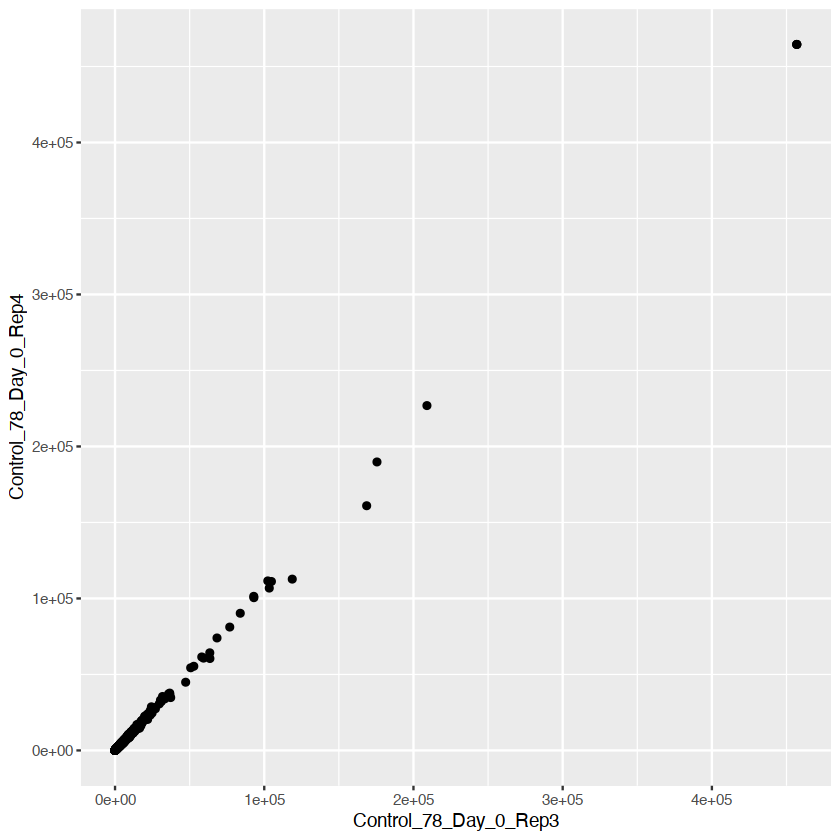

In [59]:
ggplot(data = counts_filt) + 
  geom_point(mapping = aes(x = Control_78_Day_0_Rep3, y = Control_78_Day_0_Rep4))

There are 3 key components to a ggplot: data, aesthetics (aes), and geometry (geom).

In [ ]:
ggplot(counts_filt) # just the data component

In [ ]:
ggplot(counts_filt) + geom_point() # data and geometry, but no aesthetics -- error!

In [ ]:
ggplot(counts_filt) + geom_point(aes(Control_78_Day_0_Rep3, Control_78_Day_0_Rep4)) # also works without specifying data = , mapping = , x = , y = 

In [ ]:
?ggplot # view documentation

## Data normalization
We won't get into too much detail yet, but normalization is very important in RNA-seq analysis. A simple log transformation makes the data much easier to visualize and interpret.

In [ ]:
ggplot(data = counts_filt) + 
  geom_point(mapping = aes(x = log(Control_78_Day_0_Rep3 + 1), y = log(Control_78_Day_0_Rep4 + 1))) # add 1 because log(0) is not a number

## Scatter plot interpretation

Each point in this scatterplot (or geom_point plot) is a gene, with its position defined by expression in Control Day 0 replicates. The replicates are positively correlated, suggesting they are doing the same thing. Let's compare a Control Day 0 sample to an FSHD2 sample.

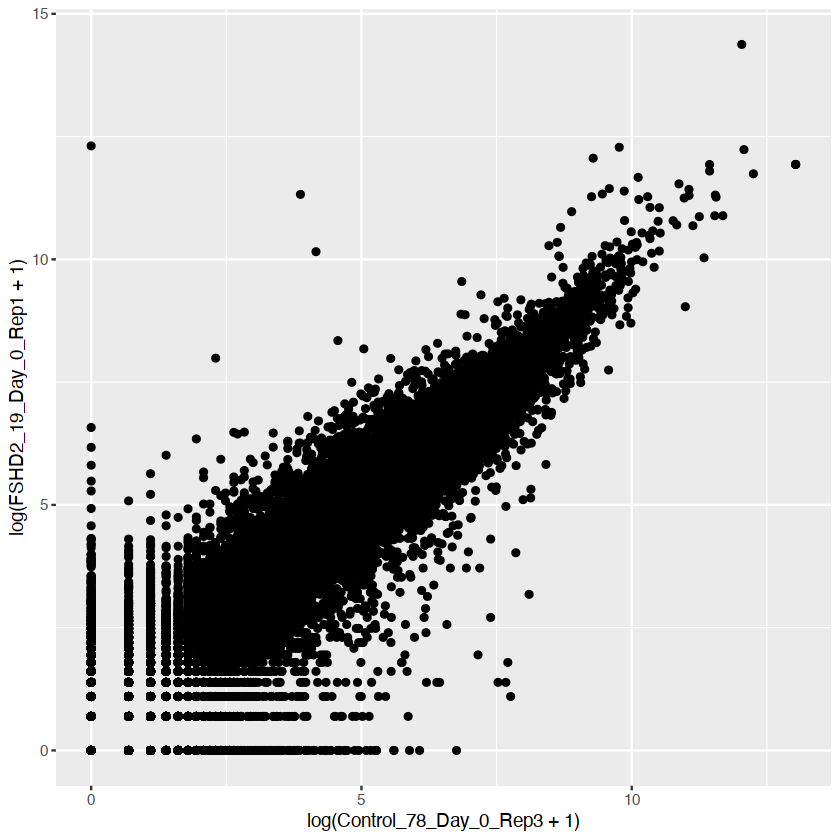

In [61]:
counts_filt2 = counts[,c(1,3,7)]

ggplot(counts_filt2) + 
  geom_point(aes(x = log(Control_78_Day_0_Rep3 + 1), y = log(FSHD2_19_Day_0_Rep1 + 1)))

Overall, the Control Day 0 sample and the FSHD2 Day 0 sample are also overall positively correlated, but you can see that the genes are more spread out with more outliers.

# PCA

We could make dozens of 2D scatterplots comparing each of our 8 samples to each other, or even 3D scatterplots to look at 3 samples at once, or we could use principal component analysis!

[Watch this 5 minute explanation of PCA](https://www.youtube.com/watch?v=HMOI_lkzW08&t=1s)

[Optional: Longer explanation](https://www.youtube.com/watch?v=FgakZw6K1QQ)

Let's return to our full `counts` data frame. We will use the `pca()` function, which requires a matrix as input. 

In [49]:
# reformat data frame to be a numerical matrix (same as before)
mat = counts[,c(3:ncol(counts))] # remove gene ID and gene name columns 1 and 2 because they are not numerical
rownames(mat) = counts$Gene_ID

In [50]:
# run PCA algorithm  
pca <- prcomp(t(log2(mat+1)))
#head(pca)
class(pca) # output is its own fancy class

[1] "prcomp"

## Plot PCA results

In [ ]:
# Grab pca output, stored in "x"
pca_out <- pca$x
head(pca_out) # a matrix with the same number of PCs as samples

pca_out = cbind(pca_out, meta)

ggplot(pca_out)+
  geom_point(aes(x=PC1,y=PC2,color=Patient)) # adding color for Patient

## PCA results visualization: [aesthetic mappings](https://r4ds.had.co.nz/data-visualisation.html#aesthetic-mappings)

Introducing a lot of customization! Try changing the colors or sizes, or replace `theme_bw()` with another theme such as `theme_void()` or `theme_classic()`.

In [ ]:
library(ggrepel) # need another package

# Get percent variance explained for x and y axes
percentage <- round(pca$sdev/sum(pca$sdev) * 100, 2)
percentage <- paste0(colnames(pca_out)[1:length(percentage)], " (", paste0(as.character(percentage), "%", ")"))

options(repr.plot.width=10, repr.plot.height=10) # notebook options to display plots with specified dimensions

ggplot(pca_out)+
    geom_point(aes(x=PC1, y=PC2, color=Patient), 
               size=5) +  # increase size of all points outside the aes() function
    xlab(percentage[1]) + ylab(percentage[2]) + # add x and y labels
    geom_label_repel(aes(x=PC1,y=PC2,label = Sample), size = 6) + # label points by Sample using ggrepel library
    theme_bw() + # ggplot comes with pre-configured themes https://ggplot2.tidyverse.org/reference/ggtheme.html
    scale_color_manual(values=c("#1b9e77", "#d95f02")) + # set custom colors for Control and Patient, can also use common color names like "red" and "blue"
    theme(text = element_text(size=20)) # increase overall font size

## PCA interpretation
PC1 separates Day 0 and Day 3, while PC2 separates FSHD2 from Control. We know that PCs are ranked by importance, so the difference in gene expression between Day 0 and Day 3 of differentiation is actually more important than the difference between gene expression betwen Control and FSHD2 cells. 

The percentage indicates the percent of variance in the dataset "explained" by the principal component, decreasing from PC1 to the last PC. The sum of all the percents = 100.

## [R coding basics](https://r4ds.had.co.nz/workflow-basics.html#workflow-basics)

# Differential expression analysis

We can statistically test for differential gene expression with the edgeR package.

Don't worry about interpreting the code for this part.

In [2]:
library(edgeR)
library(stringr)

Loading required package: limma



In [1]:
counts = read.csv("data/fshd.counts.matrix.csv")
meta <- read.csv("data/fshd.metadata.csv")

# reformat data frame to be a numerical matrix (same as before)
mat = counts[,c(3:ncol(counts))] 
rownames(mat) = counts$Gene_ID

In [4]:
# custom function
glm_test = function(mat, meta, comparison){

# Make groups to compare
group <- factor(str_sub(meta$Sample, end=-6))

# read count matrix into DGEList
y=DGEList(counts=mat, group=group)

# Filter lowly expressed genes
keep <- filterByExpr(y)
y <- y[keep, , keep.lib.sizes=FALSE]
y <- calcNormFactors(y)

# indicate reps with design matrix
design = model.matrix(~0+group, data=y$samples)
colnames(design) = levels(y$samples$group)

# fit data to generalized linear model
y=estimateCommonDisp(y)
y=estimateTagwiseDisp(y)
fit = glmQLFit(y, design)

# differential expression test
Contrast <- makeContrasts(contrasts= comparison, levels=design)
qlf <- glmQLFTest(fit, contrast=Contrast)

# Get results
table = qlf$table
table$Gene_ID = rownames(table)
return(table)
}

In [ ]:
table = glm_test(mat,meta,"Control_78_Day_3-Control_78_Day_0")


## Format results

Why did we use gene IDs rather than gene names to make our matrix? Unfortunately, there are some duplicate gene names but not gene IDs. We can get the gene names back by merging the differential expression results table with the original counts matrix. See [this page](https://dplyr.tidyverse.org/reference/mutate-joins.html) for more infomation on joining logic in tidyverse.

In [31]:

plot_table = left_join(table, counts, by = "Gene_ID")
plot_table$Comparison = "Control_78_Day_3-Control_78_Day_0"

table(duplicated(plot_table$Gene_Name)) 
table(duplicated(plot_table$Gene_ID))


FALSE  TRUE 
16109    36 


FALSE 
16145 

## [Data transformation](https://r4ds.had.co.nz/transform.html#transform)
Categorize each gene as upregulated, downregulated, or no change based on chosen cutoffs |logFC|> 1, Pvalue < 0.01 using [mutate](https://r4ds.had.co.nz/transform.html#add-new-variables-with-mutate) and [logical operators](https://r4ds.had.co.nz/transform.html#logical-operators). `ifelse()` is a base R function. If the gene's logFC >= 2.0 & PValue <  0.01 then it is assigned to be Upregulated category. If not, it is compared to logFC<= -2.0 & PValue <  0.01 and either assigned to Downregulated if these conditions are true, or else No Change.

In [56]:
plot_table <- mutate(plot_table, 
                     Categories = ifelse(logFC >= 2.0 & PValue <  0.01,"Upregulated on day 3", 
                                         ifelse(logFC<= -2.0 & PValue <  0.01 , "Downregulated on day 3", "No Change")))

head(plot_table)

,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2,Comparison,Categories
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,-0.4775390,-0.4136304,0.2521153,0.629506927,ENSG00000227232.5,WASH7P,6,20,6,13,9,6,0,14,Control_78_Day_3-Control_78_Day_0,No Change
2,0.2206432,0.7533316,0.1864380,0.677629251,ENSG00000233750.3,CICP27,24,20,27,24,37,15,19,17,Control_78_Day_3-Control_78_Day_0,No Change
3,0.4413614,0.6095683,0.9475596,0.359667869,ENSG00000241860.6,AL627309.5,12,12,9,25,21,29,25,32,Control_78_Day_3-Control_78_Day_0,No Change
4,0.4380888,2.4181646,0.4691568,0.513286203,ENSG00000279457.4,FO538757.1,96,77,121,110,18,85,75,33,Control_78_Day_3-Control_78_Day_0,No Change
5,1.8896203,1.6286391,15.5250199,0.004551178,ENSG00000228463.10,AP006222.1,25,10,39,99,26,33,58,63,Control_78_Day_3-Control_78_Day_0,No Change
6,-0.3343205,1.0974945,0.4555211,0.519299517,ENSG00000237094.12,AL732372.2,33,21,26,16,33,49,23,35,Control_78_Day_3-Control_78_Day_0,No Change


## Save results as csv file

In [57]:
write.csv(plot_table, file = "results/control_day0_day3_de_results.csv",row.names=F)

In [58]:
plot_table = read.csv("results/control_day0_day3_de_results.csv")

## Plot differential expression results
[Filter](https://r4ds.had.co.nz/transform.html#filter-rows-with-filter) the results within `geom_label_repel()` to label the most significant differentially expressed genes .

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


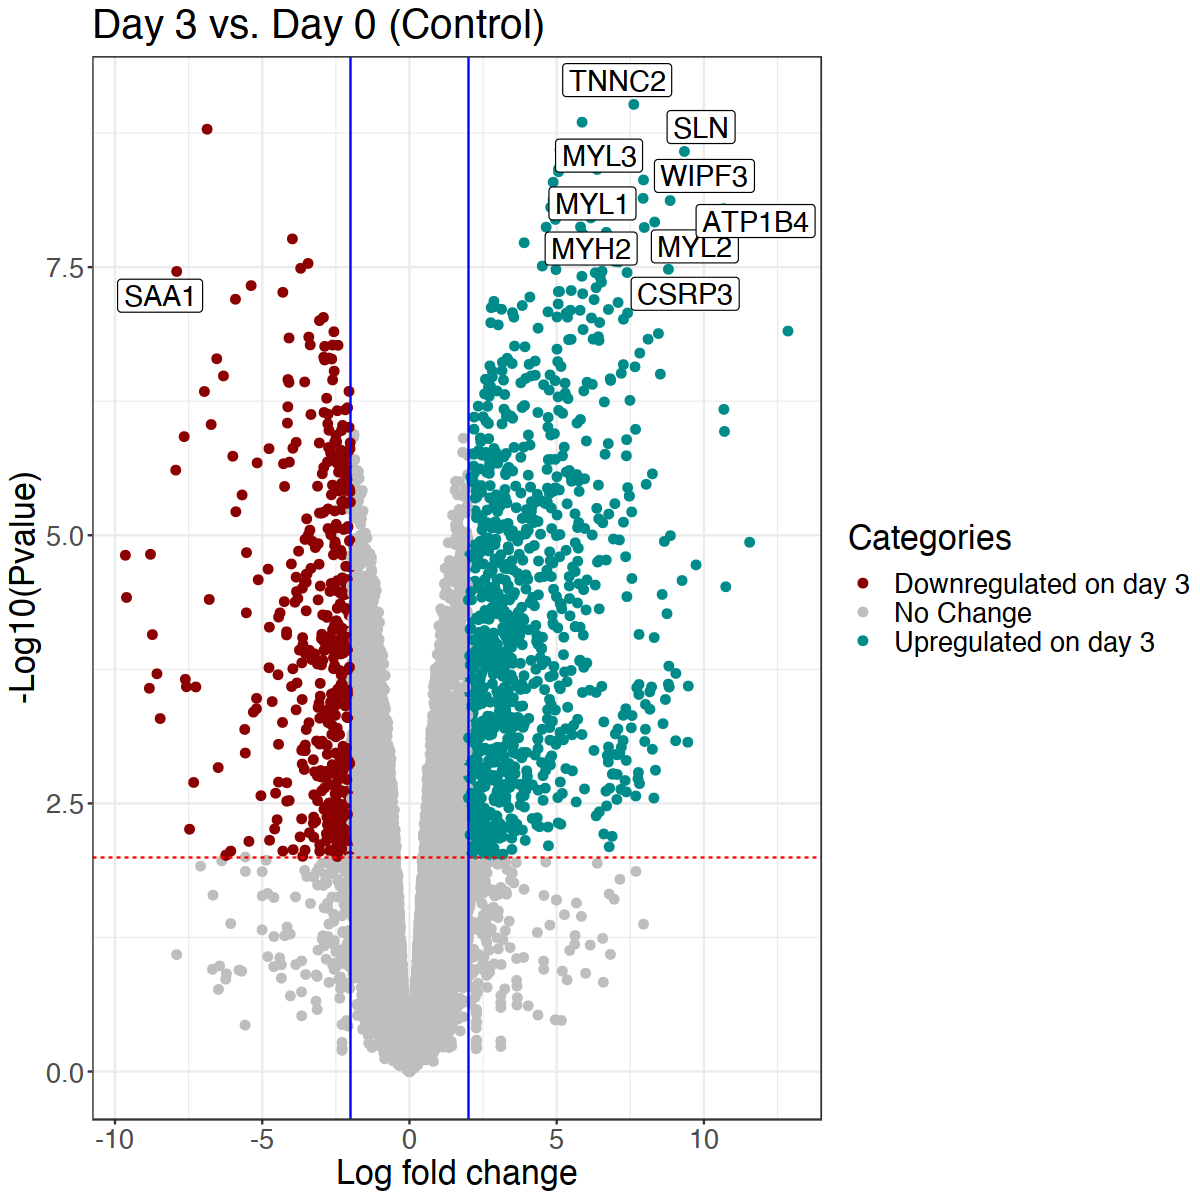

In [59]:
library(ggrepel)

options(repr.plot.width=10, repr.plot.height=10) 

ggplot(plot_table)+
    geom_point(aes(x=logFC, y=-log10(PValue), color=Categories), 
               size=2) + 
    xlab("Log fold change") + ylab("-Log10(Pvalue)") + 
    geom_label_repel(data = filter(plot_table, abs(logFC) > 7.5 & PValue < 1e-7),
                     aes(x=logFC,y=-log10(PValue),label = Gene_Name), size = 6) +
    theme_bw() +
    scale_color_manual(values=c("darkred", "grey", "darkcyan")) +
    theme(text = element_text(size=20)) +
    geom_hline(yintercept=2, linetype="dashed", # add vertical and horizontal lines to indicate significance cutoffs
             color = "red", size=0.5) +
    geom_vline(xintercept=2, color = "blue", size=0.5) +
    geom_vline(xintercept=-2, color = "blue", size=0.5) +
    ggtitle("Day 3 vs. Day 0 (Control)")


## Volcano plot interpretation and best practices

- DE statisical results are log-transformed and visualized with a volcano scatterplot
- Each point is a gene plotted by log fold change on the x-axis and -log10(Pvalue) on the y-axis
- P values are converted so that genes higher up on the y-axis are more statistically significant
- Fold change indicates the number of times more/less a gene is expressed
- Labels should clearly indicate which condition the genes are upregulated/downregulated in
- Statistical cutoffs are arbitrary; if few genes are DE, relax thresholds (for example logFC >= 0.5 / logFC<= -0.5 and Pvalue < 0.1)
- With more complicated DE test designs we can compare conditions like disease state while also accounting for other conditons like timepoint

# Heatmaps and dendrograms

There are several heatmap packages, we'll be using [ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap-reference/book/).

In [63]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [65]:
plot_table = read.csv("results/control_day0_day3_de_results.csv")

In [68]:
head(plot_table)

,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2,Comparison,Categories
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,-0.4775390,-0.4136304,0.2521153,0.629506927,ENSG00000227232.5,WASH7P,6,20,6,13,9,6,0,14,Control_78_Day_3-Control_78_Day_0,No Change
2,0.2206432,0.7533316,0.1864380,0.677629251,ENSG00000233750.3,CICP27,24,20,27,24,37,15,19,17,Control_78_Day_3-Control_78_Day_0,No Change
3,0.4413614,0.6095683,0.9475596,0.359667869,ENSG00000241860.6,AL627309.5,12,12,9,25,21,29,25,32,Control_78_Day_3-Control_78_Day_0,No Change
4,0.4380888,2.4181646,0.4691568,0.513286203,ENSG00000279457.4,FO538757.1,96,77,121,110,18,85,75,33,Control_78_Day_3-Control_78_Day_0,No Change
5,1.8896203,1.6286391,15.5250199,0.004551178,ENSG00000228463.10,AP006222.1,25,10,39,99,26,33,58,63,Control_78_Day_3-Control_78_Day_0,No Change
6,-0.3343205,1.0974945,0.4555211,0.519299517,ENSG00000237094.12,AL732372.2,33,21,26,16,33,49,23,35,Control_78_Day_3-Control_78_Day_0,No Change


In [93]:
# Input to ComplexHeatmap must be a matrix
plot_table_up = plot_table[plot_table$Categories == "Upregulated on day 3",]
rownames(plot_table_up) = plot_table_up$Gene_Name
plot_table_up = as.matrix(plot_table_up[,colnames(plot_table) %in% meta$Sample])

# Log transform and scale rows between 0 and 1 
plot_table_up = apply(log2(plot_table_up+1), MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))

head(plot_table_up)

,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2
HES4,0.0000000,0.0000000,0.06453147,0.10477655,0.1166311,0.0000000,0.3433492,0.3721385
AGRN,0.3400437,0.2558565,0.30060123,0.29036135,0.4554847,0.4788265,0.5284718,0.5509351
CFAP74,0.1399939,0.1095878,0.12305445,0.07884176,0.2444475,0.1911364,0.1948789,0.2246716
PLCH2,0.0000000,0.0000000,0.00000000,0.00000000,0.2207581,0.2075805,0.3755365,0.3695994
MEGF6,0.1625278,0.1095878,0.13470704,0.07268661,0.3537542,0.3140988,0.4310324,0.4025004
HES2,0.2218850,0.1605432,0.28005690,0.27413376,0.2332622,0.1478833,0.3315059,0.3444004


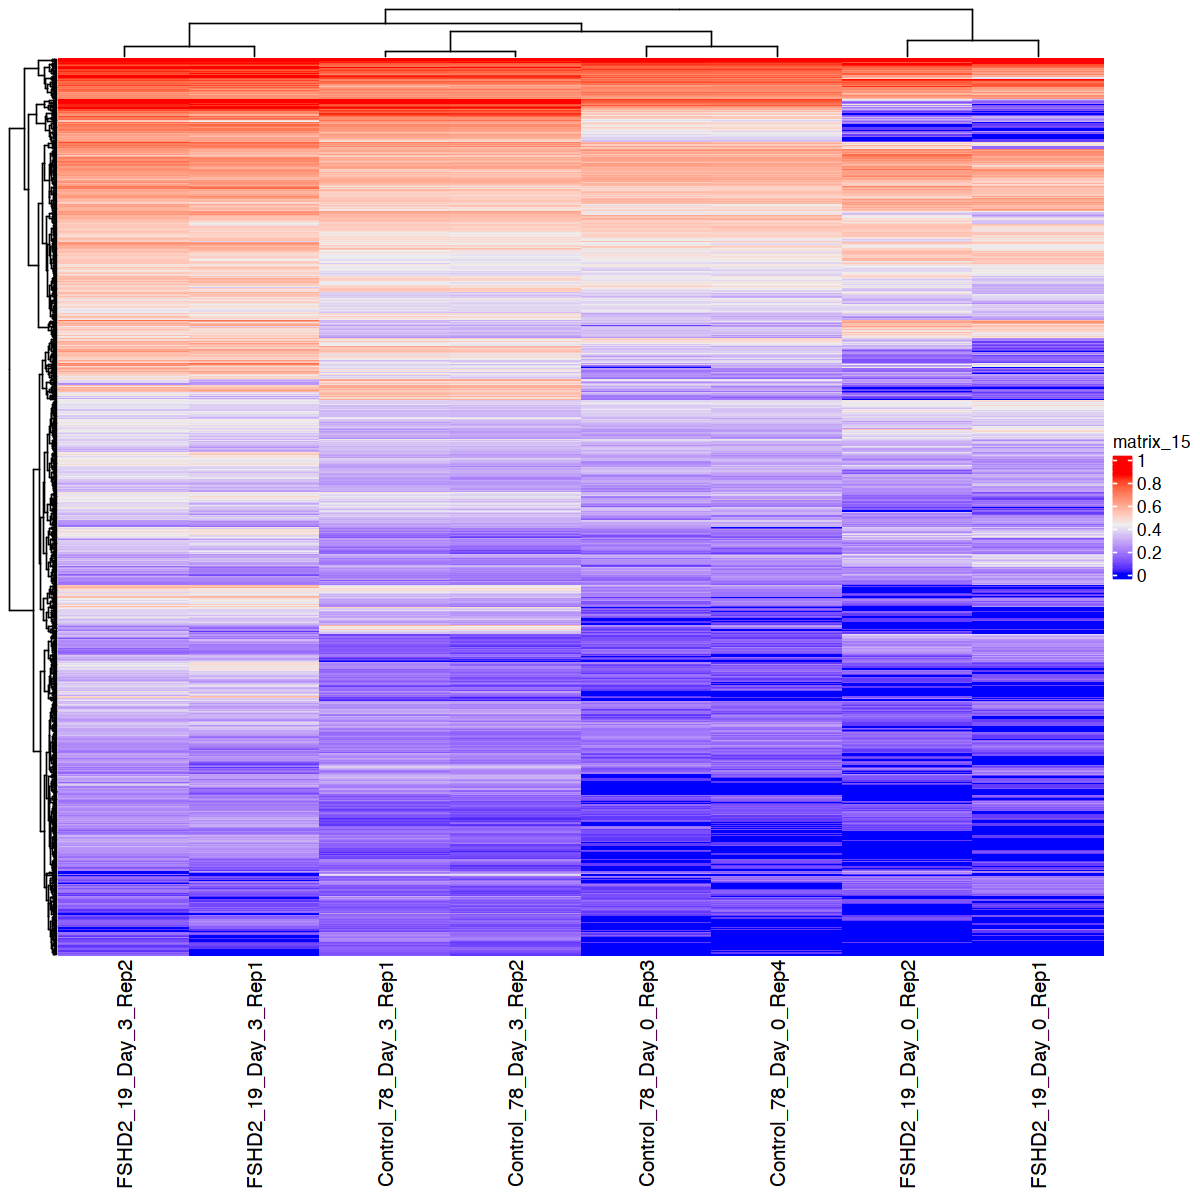

In [101]:
Heatmap(plot_table_up, show_row_names = FALSE)

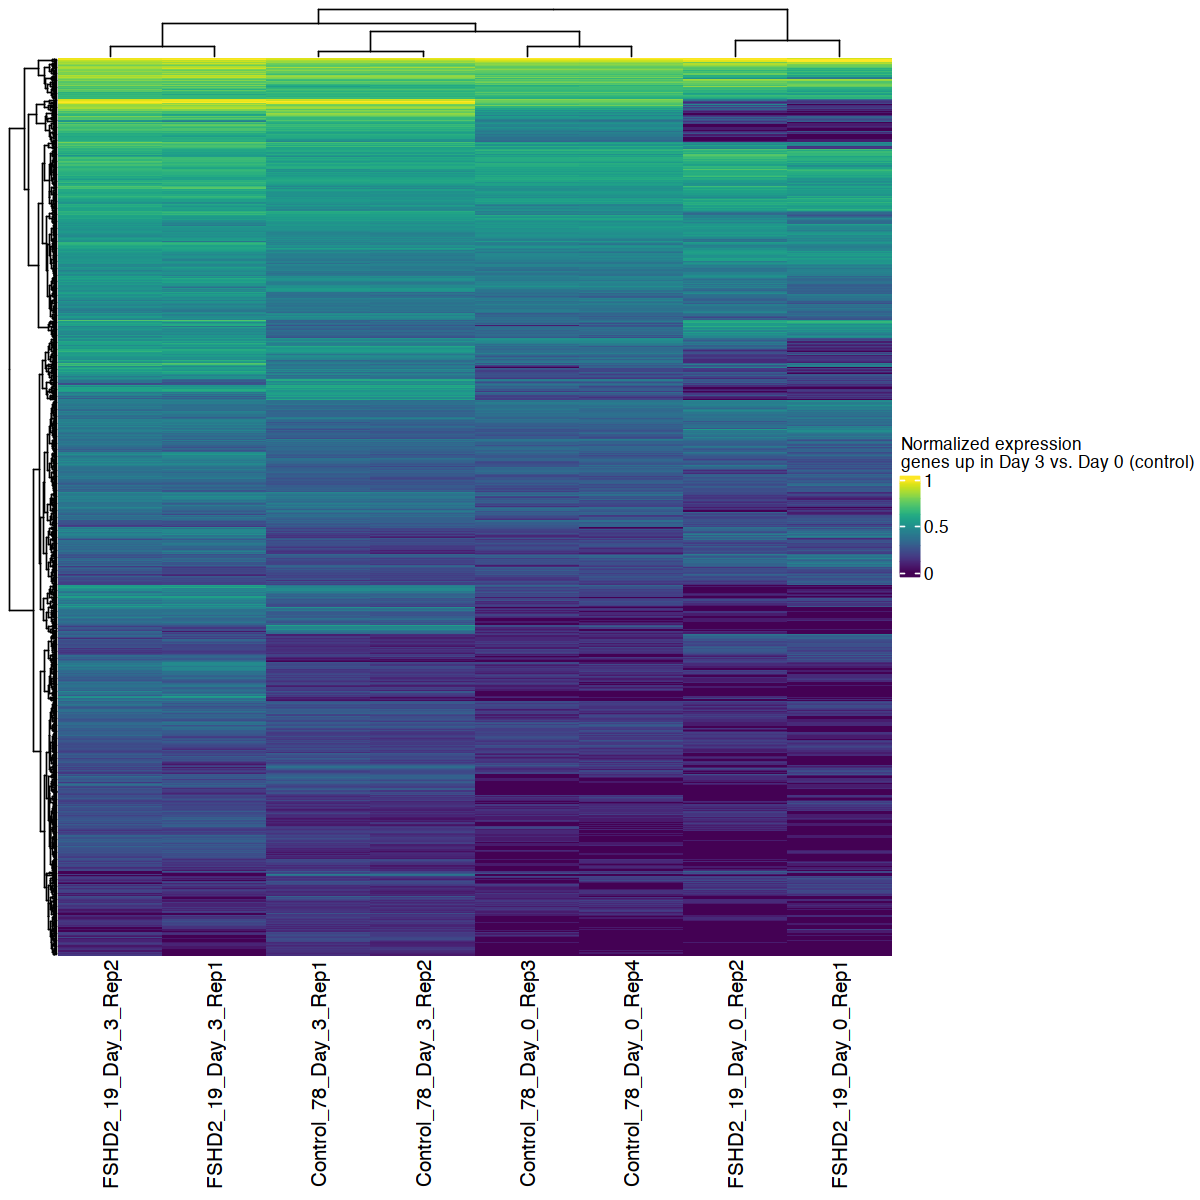

In [100]:
# Play with colors
library(viridis)
Heatmap(plot_table_up, name = "Normalized expression\ngenes up in Day 3 vs. Day 0 (control)", show_row_names = FALSE, col = viridis(100))

## Heatmap interpretation and best practices

- Use colorblind friendly palettes like viridis
- Ideally use normalized data such as TPM (transcripts-per-million) rather than log-normalized counts
- Scale from 0 to 1 within each gene (row)
- Ask yourself if the sample (column) clustering makes sense (are there any outliers?)
- Both large (>1,000 genes) and small (< 10 genes) heatmaps can be useful